In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

def return_scaled_dataframe(dataframe, scaler = StandardScaler()):
    
    to_scale_features = dataframe.select_dtypes([np.number]).columns
    scaled_features = dataframe[to_scale_features].copy()
    scaled_columns = scaled_features.columns
    scaled_features[scaled_columns] = scaler.fit_transform(scaled_features)

    return scaled_features


def clustering_metrics(data):
    
    Sum_of_squared_distances = []
    Silhouette_value = []
    Calinski_Harabasz = []
    Davies_Bouldin = []

    K = range(2, 20 + 1)

    for k in K:

        km = KMeans(n_clusters = k, n_init = 20, max_iter = 500, random_state = 20202020)
        km = km.fit(data)
        labels = km.labels_

        Sum_of_squared_distances.append(km.inertia_)
        Silhouette_value.append(silhouette_score(data, labels, metric = 'euclidean'))
        Calinski_Harabasz.append(calinski_harabasz_score(data, labels))
        Davies_Bouldin.append(davies_bouldin_score(data, labels))

    fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 7))

    sns.pointplot(x = list(K), y = Sum_of_squared_distances, markers = 'x', s = 10, ax = ax[0, 0])
    sns.pointplot(x = list(K), y = Silhouette_value, markers = 'x', s = 10, ax = ax[1, 0])
    sns.pointplot(x = list(K), y = Calinski_Harabasz, markers = 'x', s = 10, ax = ax[0, 1])
    sns.pointplot(x = list(K), y = Davies_Bouldin, markers = 'x', s = 10, ax = ax[1, 1])

    ax[0, 0].title.set_text('Sum of squared distances ("elbow")')
    ax[1, 0].title.set_text('Silhouette value')
    ax[0, 1].title.set_text('Calinski-Harabasz')
    ax[1, 1].title.set_text('Davies-Bouldin')

    plt.show()
    
def plot_clusters(data, x, y):
    
    fig = px.scatter(data, x = x, y = y, color = 'clusters', hover_data = ['Team', 'season'],
                     title = 'Clusters plotted via reduced dimensionality', 
                     labels = {'season' : 'Season'},
                     width = 750, height = 550)
    fig.update_layout(showlegend=True)
    fig.show()
    
def show_diff_between_clusters(data = cluster_exploration):
    
    fig = px.box(data_frame = data, y = 'value', x = 'clusters', color = 'clusters',
                 facet_row_spacing = 0.05, facet_col_spacing = 0.05,
                  title = 'Distribution differences across clusters', facet_col = 'stat', facet_col_wrap = 3,
                  width = 950, height = 1950)

    fig.update_xaxes(visible = True, showticklabels = True, title = None, matches = None, type = 'category', categoryorder='category ascending')
    fig.update_yaxes(visible = True, showticklabels = True, title = None, matches = None)
    fig.for_each_annotation(lambda a: a.update(text = a.text.split('=')[-1]))
    fig.update_traces(marker = {'size' : 4}, line = {'width' : 1})
    fig.update_layout(showlegend=False)
    fig.show()

### Data

In [215]:
data = pd.read_csv('data/scraped_for_modeling_labeled.csv')
data.drop(['games_played'], 1, inplace = True)
data.fillna(0, inplace = True) # divisions with 0

# from borutapy
keep_cols = ['offense_downs_Fourth Downs_PCT', 'offense_passing_AVG', 'offense_passing_YDS/G', 'offense_passing_RTG', 
             'offense_receiving_AVG', 'defense_passing_AVG', 'defense_passing_RTG', 'defense_receiving_AVG', 
             'punting_punts_per_game', 'defense_passing_SYL_per_game', 'offense_downs_Third Downs_ATT_per_game', 
             'defense_downs_Third Downs_ATT_per_game', 'defense_downs_Fourth Downs_ATT_per_game', 
             'defense_downs_First Downs_penalty_ratio', 'offense_passing_TD_per_game', 
             'offense_passing_INT_per_game', 'defense_passing_INT_per_game', 'offense_pass_TD_to_INT', 
             'defense_pass_TD_to_INT']
data = data[['Team', 'season', 'winner', 'played'] + keep_cols].copy()

without_targets = data.drop(['winner', 'played', 'Team', 'season'], 1).copy()
with_targets = data.drop(['winner', 'Team', 'season'], 1).copy()

### Scaling

In [216]:
without_targets_scaled = return_scaled_dataframe(without_targets)
with_targets_scaled = return_scaled_dataframe(with_targets)

### Clustering metrics

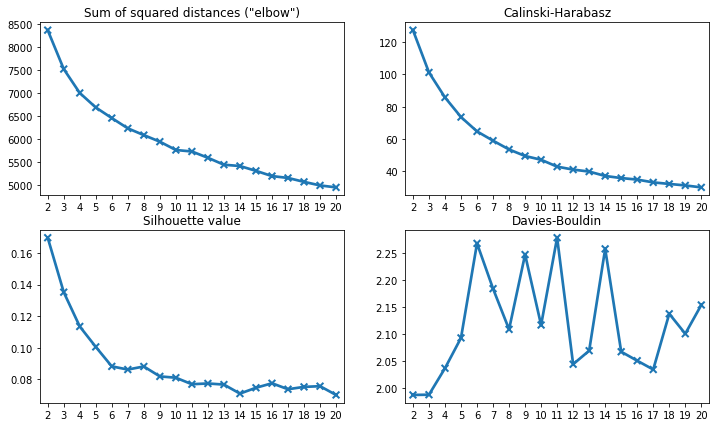

In [217]:
clustering_metrics(without_targets_scaled)

4-5 clusters are probably enough

### Running PCA and plotting clusters

In [218]:
pca = PCA(random_state = 20202020)
pca.fit(without_targets_scaled)

comp = pd.DataFrame(pca.components_, columns = without_targets_scaled.columns)
exp_var = pd.DataFrame(pca.explained_variance_ratio_ * 100, columns = ['Explained variance % '])

pca_results = pd.concat([exp_var, comp], 1)
pca_results.head()

,Explained variance %,offense_downs_Fourth Downs_PCT,offense_passing_AVG,offense_passing_YDS/G,offense_passing_RTG,offense_receiving_AVG,defense_passing_AVG,defense_passing_RTG,defense_receiving_AVG,punting_punts_per_game,defense_passing_SYL_per_game,offense_downs_Third Downs_ATT_per_game,defense_downs_Third Downs_ATT_per_game,defense_downs_Fourth Downs_ATT_per_game,defense_downs_First Downs_penalty_ratio,offense_passing_TD_per_game,offense_passing_INT_per_game,defense_passing_INT_per_game,offense_pass_TD_to_INT,defense_pass_TD_to_INT
0,29.419874,0.130610,0.380195,0.315261,0.402892,0.224298,0.028530,0.038313,-0.027108,-0.323898,0.097933,-0.236614,-0.189483,0.187157,0.020199,0.353649,-0.228191,0.026959,0.321623,0.014896
1,18.595166,0.023796,-0.016432,0.102012,-0.037484,-0.060613,0.452594,0.489404,0.270886,-0.083909,-0.181517,-0.082013,-0.223634,-0.204287,-0.058006,-0.004606,0.121052,-0.383637,-0.070680,0.396571
2,7.234122,0.083702,-0.128993,-0.005155,0.095153,-0.245408,-0.137083,0.097437,-0.135473,0.158031,0.356944,0.257663,0.113090,0.005519,0.549856,0.030469,-0.292630,-0.336426,0.207202,0.289482
3,6.855780,-0.296500,0.184463,0.154773,-0.099357,0.342329,-0.242054,0.064554,-0.358645,-0.095373,0.184616,-0.200869,0.245298,0.042722,0.096993,0.023052,0.417438,-0.244119,-0.286988,0.252960
4,6.700175,-0.112168,0.137184,0.260026,-0.015550,0.341590,0.153301,-0.130441,0.516686,0.191345,0.194413,0.305588,0.078093,-0.287944,0.336848,0.155798,0.178019,0.187354,-0.049497,-0.113109


In [219]:
CLUST_NUMBER = 4

PCAs = pd.DataFrame(pca.transform(without_targets_scaled))[[0, 1]]
PCAs.columns = ['PCA_1', 'PCA_2']

km = KMeans(n_clusters = CLUST_NUMBER, n_init = 20, max_iter = 500, random_state = 20202020).fit(without_targets_scaled)
km = pd.DataFrame(km.predict(without_targets_scaled), columns = ['clusters'])
kmeans_results = pd.concat([data[['Team', 'season']], PCAs, km], 1)
kmeans_results.clusters = kmeans_results.clusters.astype('object')

kmeans_results.head(3)

,Team,season,PCA_1,PCA_2,clusters
0,Kansas City Chiefs,2004,2.647251,3.590970,3
1,Indianapolis Colts,2004,7.338932,-0.733455,0
2,Green Bay Packers,2004,1.873449,3.342105,3


In [220]:
kmeans_results.clusters.value_counts()

1    167
2    140
3    126
0    111
Name: clusters, dtype: int64

In [221]:
plot_clusters(kmeans_results, 'PCA_1', 'PCA_2')

#### TSNE visualization

In [222]:
# tsne = TSNE(n_components = 2, verbose = 0, random_state = 20202020).fit_transform(without_targets_scaled)
# tsne_plot = pd.DataFrame(tsne)[[0, 1]]
# tsne_plot.columns = ['tSNE_1', 'tSNE_2']
# tsne_results = pd.concat([data[['Team', 'season']], tsne_plot, km], 1)
# tsne_results.clusters = tsne_results.clusters.astype('object')

# plot_clusters(tsne_results, 'tSNE_1', 'tSNE_2')

#### Explore differences across clusters

In [223]:
cluster_exploration = pd.concat([data, km], 1)

cluster_vs_win = cluster_exploration.pivot_table(index = 'clusters', columns = 'winner', values = 'Team', aggfunc = 'count').fillna(0).astype(int)
cluster_vs_play = cluster_exploration.pivot_table(index = 'clusters', columns = 'played', values = 'Team', aggfunc = 'count').fillna(0).astype(int)

cluster_exploration_melt = pd.melt(cluster_exploration, id_vars = ['Team', 'season', 'clusters', 'winner', 'played'], 
                              var_name = 'stat', value_name = 'value')

In [224]:
cluster_vs_win

winner,0,1
clusters,,
0,100,11
1,162,5
2,139,1
3,126,0


In [225]:
cluster_vs_play

played,0,1
clusters,,
0,88,23
1,158,9
2,139,1
3,125,1


In [226]:
show_diff_between_clusters(cluster_exploration_melt)

Some team in cluster '2' was very successful compared to its cohort - NYG of 2007, ending the Pats' undefeated season

In [227]:
cluster_exploration[(cluster_exploration['clusters'] == 2) &
                    (cluster_exploration['winner'] == 1)]

,Team,season,winner,played,offense_downs_Fourth Downs_PCT,offense_passing_AVG,offense_passing_YDS/G,offense_passing_RTG,offense_receiving_AVG,defense_passing_AVG,...,offense_downs_Third Downs_ATT_per_game,defense_downs_Third Downs_ATT_per_game,defense_downs_Fourth Downs_ATT_per_game,defense_downs_First Downs_penalty_ratio,offense_passing_TD_per_game,offense_passing_INT_per_game,defense_passing_INT_per_game,offense_pass_TD_to_INT,defense_pass_TD_to_INT,clusters
103,New York Giants,2007,1,1,35.3,6.2,197.1,73.0,11.2,7.0,...,13.6875,13.1875,1.0,0.069444,1.4375,1.25,0.9375,1.15,1.6,2
